# Machine learning with the Open Data Cube  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_gm_2_annual](https://explorer.digitalearth.africa/ga_ls8c_gm_2_annual)
* **Special requirements:** A shapefile of labelled data in shapefile format is required to use this notebook.
An example dataset is provided.

* **Prerequisites:** A basic understanding of supervised learning techniques is required. 
    * [Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with - it can be downloaded for free [here](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf). 
    * The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.
    * This [article](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343) provides a nice review of machine learning in the context of remote sensing.


## Description

This notebook demonstrates a potential workflow using functions from the [deafrica_classificationtools](../Scripts/deafrica_classificationtools.py) script to implement a `supervised learning` landcover classifier within the [ODC (Open Data Cube)](https://www.opendatacube.org/) framework. The notebook uses a default shapefile of training data that has been provided for demonstration uses only.

> **Note**: Users who have their own training data can directly import their own shapefile by adjusting the `path` parameter.

The notebook demonstrates how to:

1. Train a simple decision tree model and adjust parameters. 
2. Predict landcover using the trained model on new data.
3. Plot the results and visually assess the classification
3. Evaluate the output of the classification using quantitative metrics
4. Export the results as a geotiff

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import os
import datacube
import dask
from pprint import pprint
import pydotplus
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree, model_selection
from sklearn.model_selection import GridSearchCV
from datacube_stats.statistics import GeoMedian
from sklearn.metrics import accuracy_score
from datacube.utils.dask import start_local_dask
from datacube.helpers import write_geotiff
from joblib import dump
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../Scripts')
from deafrica_classificationtools import predict_xr, get_training_data_for_shp 
from deafrica_plotting import map_shapefile, rgb
from deafrica_datahandling import mostcommon_crs, load_ard
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:44747' processes=1 threads=2, memory=14.18 GB>

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [3]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `lat`, `long` & `buffer`: The centre location and buffer for your area of interest, this will define the box from which we extract satellite data to classify when we make the prediction.
* `path`: The path to the input shapefile. A default shapefile is provided.
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. In this example we use a geomedian composite from 2018, `'ga_ls8c_gm_2_annual'`
* `time`: The time range you wish to extract data for, typically the same date the labels were created.
* `reduce_func`: This will determine the statistic to reduce the time dimension of the loaded datasets (if loading multiple time steps). Options include `'mean'`, `'median'`, or `'geomedian'`. 
* `band_indices`: a list of band indices to calculate for the training data see [here](../Frequently_used_code/Calculating_band_indices.ipynb) for possible options.
* `collections`: In order to calculate band indices, the function needs to know which product we are using. Options include `'s2'` for Sentinel-2, `'c1'` for Landsat Collection 1, and `'c2'` for Landsat Collection 2.
* `drop`: If calculating band indices, we can optionally choose to drop the spectral bands loaded with the product, if `'drop=True'`, then only the band indices will be used for the training data.
* `zonal_stats`: This is an option to calculate the `'mean'` or `'median'` of the pixel values within each polygon feature, setting it to `None` will result in all pixels being extracted.
* `dask_chunks`: A dictionary of dimensions to 'chunk' our data by during loading e.g. `{'x':500, 'y':500, 'time':-1}`
* `resolution`: The spatial resolution, in metres, to resample the satellite data too e.g. if working with Landsat data, then this should be `(-30,30)` 
* `align`: How to align the pixel coordinates. e.g if working with Landsat data, then this should be `(15,15)`, which corresponds to the centre of a 30x30m pixel

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. 

In [4]:
# a city in Ghana
lat = 6.853
long = -1.393
buffer = 0.05

path = '../Supplementary_data/Machine_learning_with_ODC/test_training_data.shp' 
field = 'class'
products = ['ga_ls8c_gm_2_annual']
time = ('2018')
reduce_func = None #'geomedian'
band_indices = None #['NDVI', 'NDBI'] 
collection = None #'c1' 
drop = False
zonal_stats = None #'median' 
dask_chunks = {'x':500, 'y':500, 'time':-1}
resolution =  (-30, 30)
align = (15,15)


## Extract training data using a shapefile

**Training data** is the most important part of any machine learning workflow. The quality of the training data has a greater impact of the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy (Huang, Davis and Townsend 2002).  

When creating training data, be sure to capture the `spectral variability` of the class, and to use imagery from the time period you want to classify (rather than relying on basemap composites). The best way to create training data is using a GIS platform. 

Another common problem with training data is `class imbalance`. This can occur when one of your classes is relatively rare and therefore the rare class will comprise a smaller proportion of the training set. When imbalanced data is used, it is common that the final classification will under-predict less abundant classes relative to their true proportion.

> **Note**: The training data provided by default is `for demonstration purposes only` and should not be relied upon for real world analysis.  

***

Firstly, let's open our training data and visualize it using the function `map_shapefile`

In [5]:
#open shapefile and ensure its in WGS84 coordinates
input_data = gpd.read_file(path).to_crs('epsg:4326')

#check the shapfile by plotting it
map_shapefile(input_data, attribute=field)

Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations. 
The function `get_training_for_shp` takes our shapefile containing class labels and extracts the specified product within these areas into a single array.


> **The following cell can take several minutes to run.** The class labels will be contained in the first column of the output array.


In [6]:
#generate a datacube query object
query = {
    'time': time,
    'measurements': ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'],
    'dask_chunks': dask_chunks,
    'resolution': resolution,
    'align' : align,
    'group_by' :'solar_day',
}


In [7]:
# Empty list which we will populate with data
out = []

# Call the extraction function
column_names = get_training_data_for_shp(polygons=input_data, 
                                         out=out,
                                         products=products,
                                         dc_query=query,
                                         field=field,
                                         calc_indices=band_indices,
                                         drop=drop,
                                         reduce_func=reduce_func,
                                         zonal_stats=zonal_stats,
                                         collection=collection)


In [8]:
# Stack the extracted training data for each feature into a single array
model_input = np.vstack(out)
print(f'\nOutput training data has shape {model_input.shape}')


Output training data has shape (1640, 7)


## Preprocessing

`scitkit-learn` models cannot accept training data with `NaNs` ("not a number"). 
This preprocessing step removes any potential rows in the training array with `NaNs`.

In [9]:
# Remove any potential nans
model_input = model_input[~np.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (1640, 7)


Our training data has multiple classes in it. However, we are only trying to predict one class (i.e. class 'urban') with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

In the cell below, set the class number that corresponds with the 'urban' training class in the shapefile

In [10]:
urban_class_int = 1

In [11]:
# Modify the input training data for single class labels
model_input[:,0] = np.where(model_input[:,0] == urban_class_int, 1, 0)

So that we can access the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [12]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (1312, 7)
Test shape: (328, 7)


## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [13]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below by adding or changing variables in the `classifier_params` below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [14]:
classifier_params = {'criterion': 'gini',
                     'max_depth' : 20,
                     'splitter' : 'random',
                     'min_samples_split' : 100}

model = tree.DecisionTreeClassifier(**classifier_params)

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [15]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

### Optionally save the model

Running this cell will export the classifier as a binary`.joblib` file. This will allow for importing the model in other scripts should we wish to use the same model to classify a different region

In [16]:
dump(model, 'ml_model.joblib')

['ml_model.joblib']

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.


In [17]:
# Load the data based on query around the user supplied
# lat/long and buffer 
q = {'x': (long-buffer, long+buffer),
     'y': (lat+buffer, lat-buffer)}
query.update(q)

if 'dask_chunks' in query:
    chunks = query.pop('dask_chunks', None)
        
#get output crs    
output_crs = mostcommon_crs(dc=dc, product=products, query=query)

#load geomedian data
data = dc.load(product='ga_ls8c_gm_2_annual', **query)
data = data.where(data!=0, np.nan)

In [18]:
# Predict landcover using the trained model
predicted = predict_xr(model, data, progress=True)

## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - Use the `Evaluate Classifier` steps below to help you improve the model

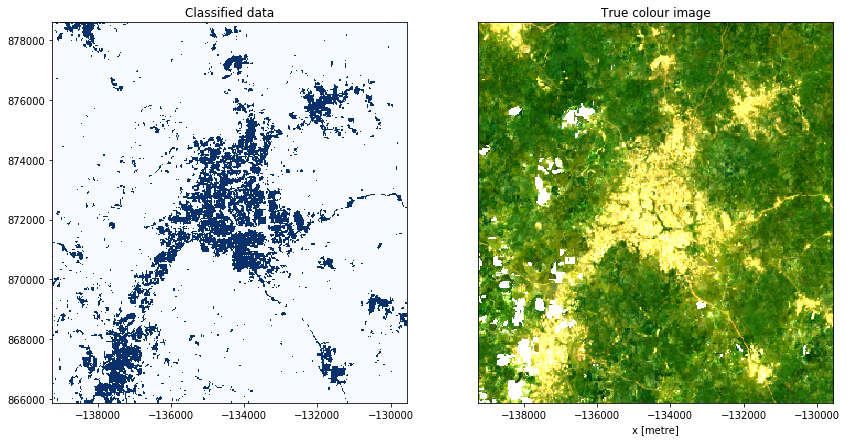

In [19]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot classified image
predicted.plot(ax=axes[0], 
               cmap='Blues', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(data, ax=axes[1], percentile_stretch=(0.05, 0.95))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

---

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
* Determining our overall accuracy,
* Finding out which features (bands in the input data) are most useful for classifying, and which are not,
* Plotting the Decision Tree to help us understand which thresholds are used to seperate the classes,
* Testing different input parameters to help us optimise the model 

### Overall Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [20]:
predictions = model.predict(model_test[:, model_col_indices])
str(round(accuracy_score(predictions, model_test[:, 0], 2) *100)) + ' %'

'57.0 %'

### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

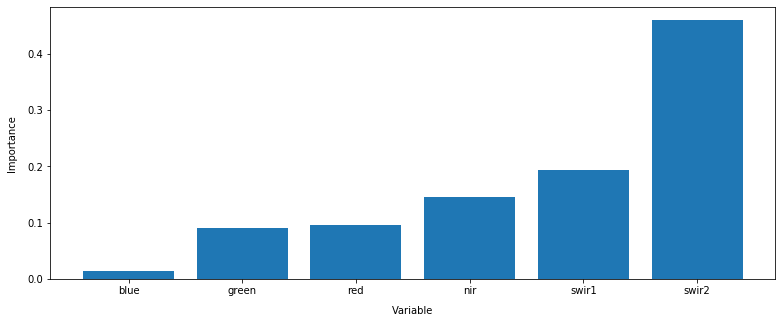

In [21]:
# This shows the feature importance of the input features for predicting the class labels provided
plt.figure(figsize=(13,5))
plt.bar(x=model_variables, height=np.sort(model.feature_importances_))
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

### Plot the Decision Tree

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** (or **entropy**) value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

> This step can take a long time if using `feature_stats = None`

If the graph is small double-click to enlarge it. Double-click again to return to initial size.

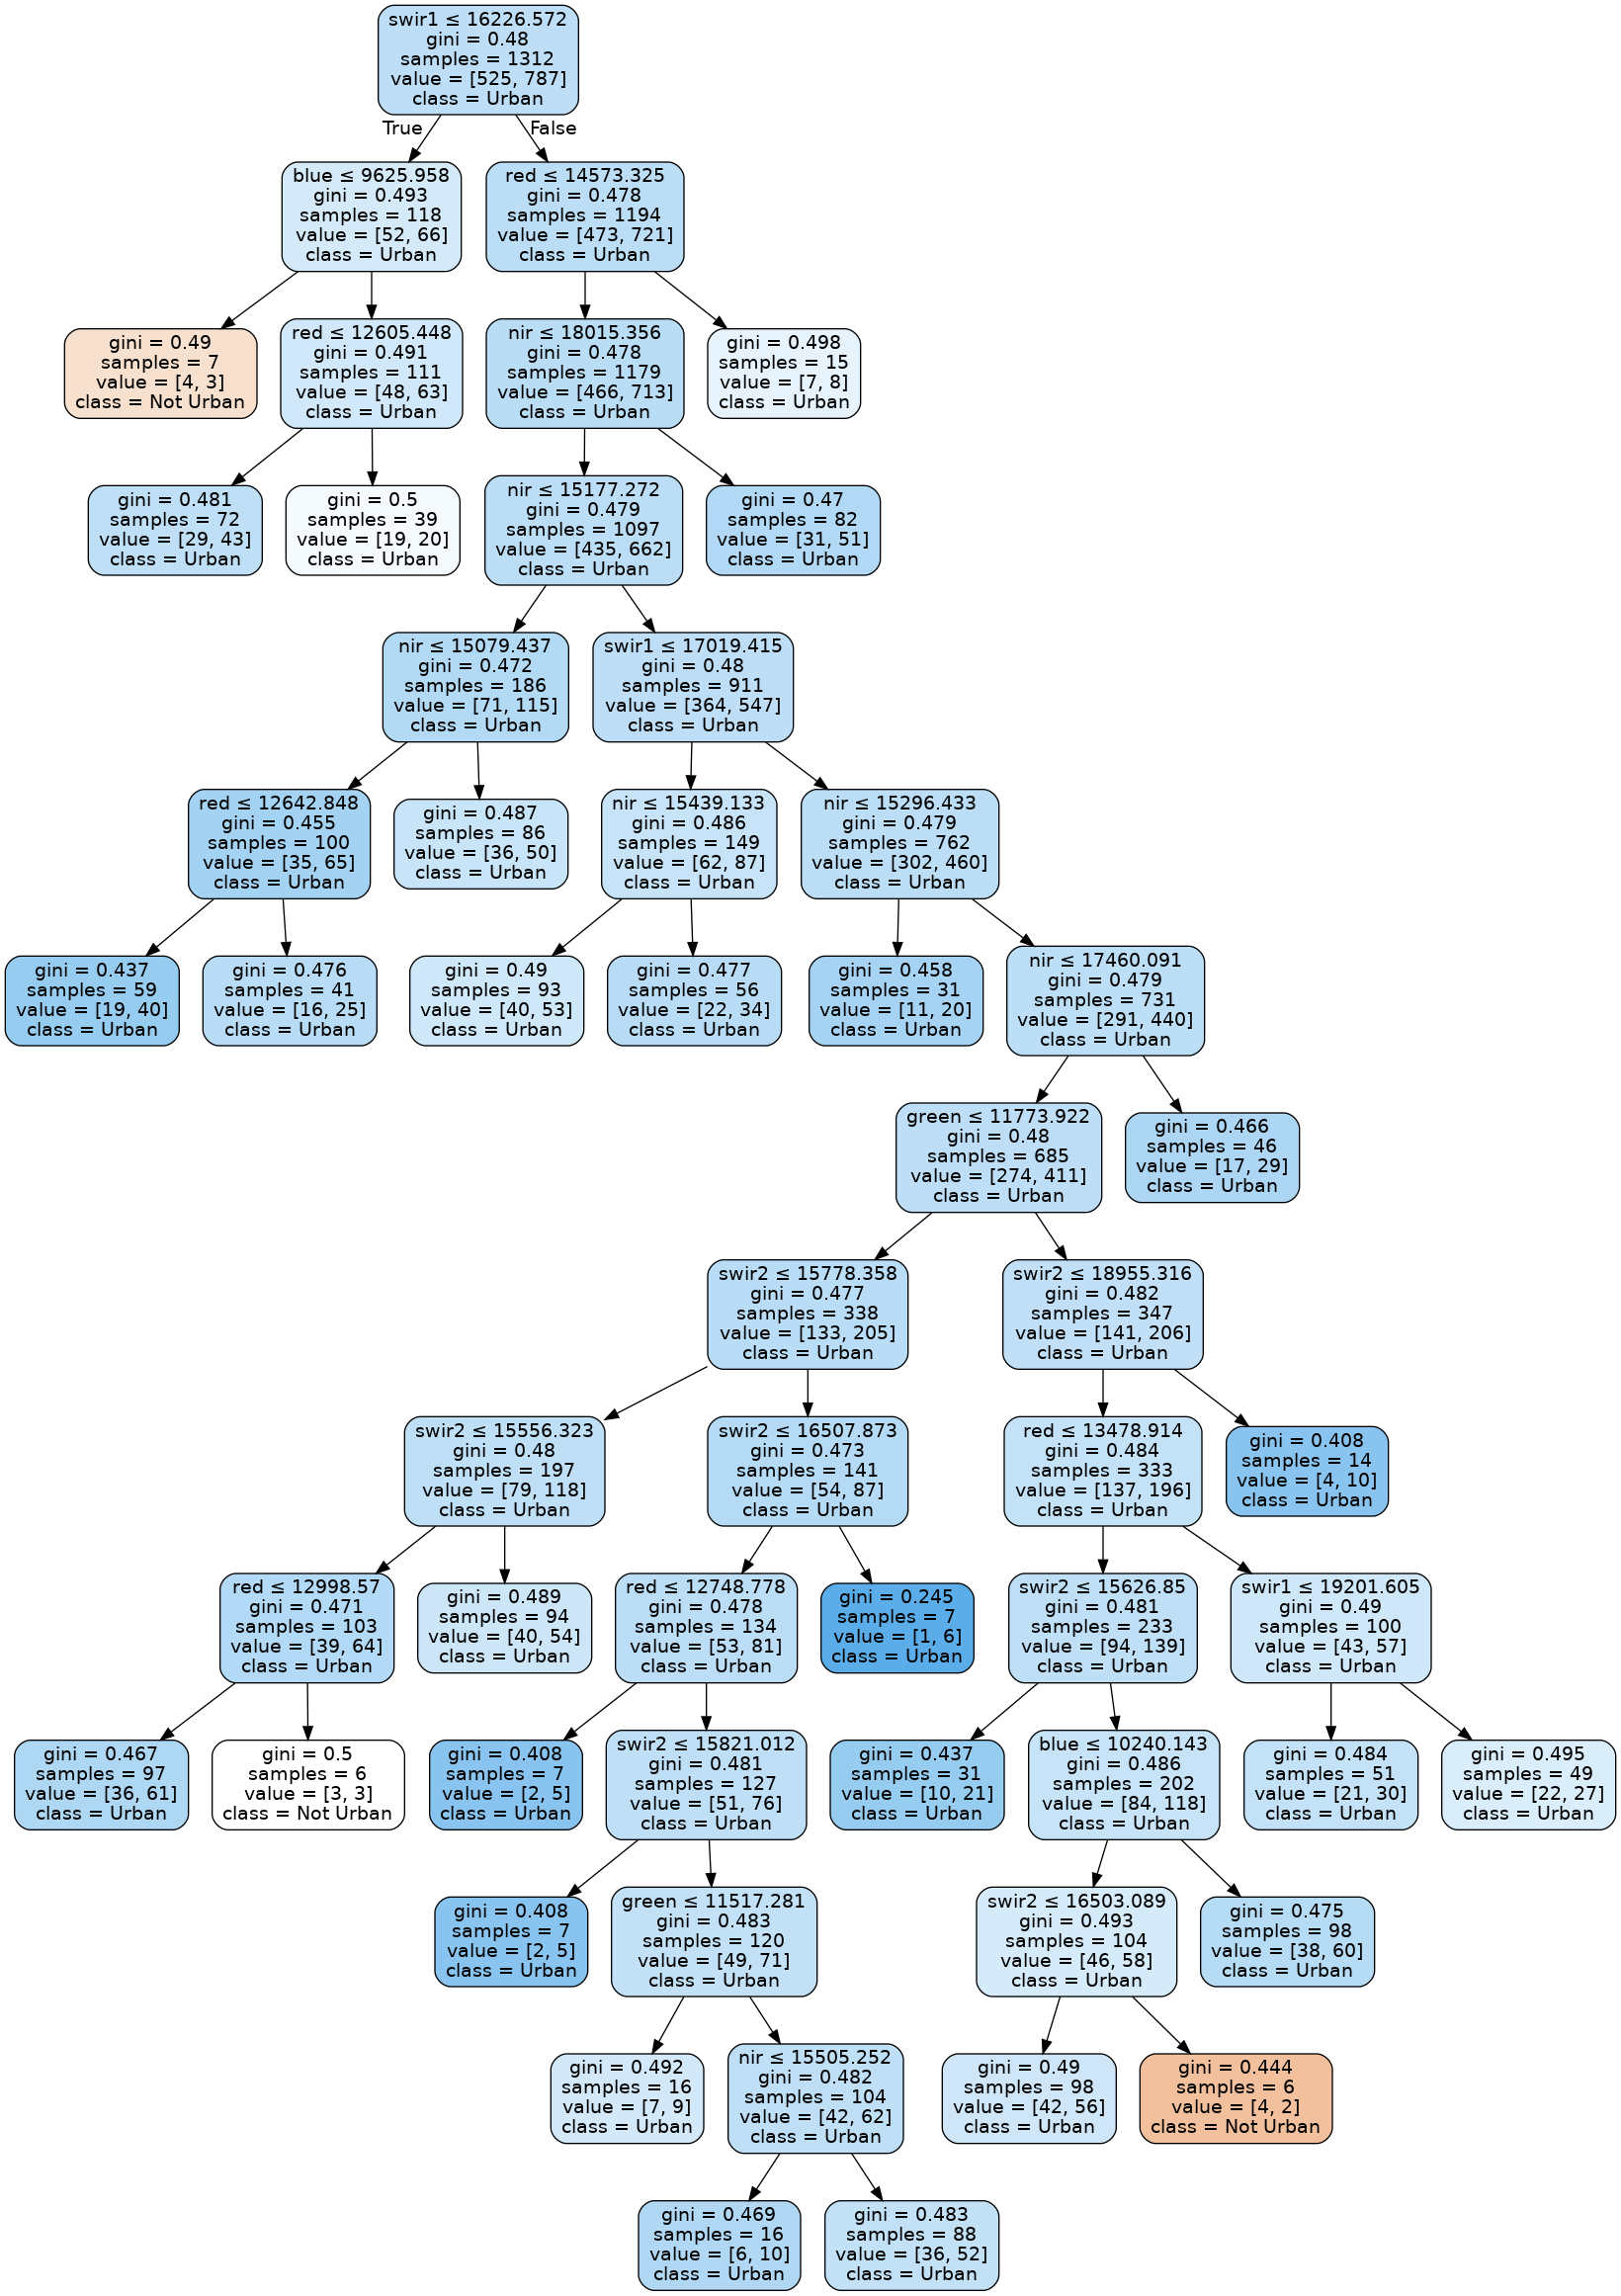

In [22]:
# Prepare a dictionary of class names
class_names = {1: 'Urban',
               0: 'Not Urban'}

# Get list of unique classes in model
class_codes = np.unique(model_train[:, 0])
class_names_in_model = [class_names[k] for k in class_codes]

# Plot decision tree
dot_data = StringIO()
tree.export_graphviz(model, 
                     out_file=dot_data, 
                     feature_names=model_variables, 
                     class_names=class_names_in_model,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph = Image(graph.create_png())
graph

### Test parameter values of model

This will help us determine which paramater values are best to use for our model. The function [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) will exhaustively search through the parameters in `param_grid` and determine the combination that will result in the highest accuracy (based on the `out-of-bag` metric).

> **Note**: if your training data is poor, then the optimisation using the out-of-bag metric will also be poor. The default training data used for this example should not be trusted for optimising this model due to its small size.

You can enter more parameters into the `param_grid` object, but be aware that the number of iterations to check will become exponentially larger as you enter more parameters. It's better practice to check only those parameters you think are likely to make a big difference to the model's accuracy. The code below will take a few minutes to run.

In [23]:
param_grid = {
    "splitter": ['best', 'random'],
    "min_samples_split" : [2,5,10,50,100],
    'criterion': ['entropy', 'gini'],
    'max_depth': [3,5,10,20],
    'min_samples_leaf': [1,3,5,10]
}

grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(model_train[:, model_col_indices], model_train[:, 0])

print("The most accurate combination of tested parameters is: ")
pprint(grid_search.best_params_)

The most accurate combination of tested parameters is: 
{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'random'}


## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [24]:
# Write the predicted data out to a GeoTIFF
predicted_ds = predicted.to_dataset(name="predicted")
predicted_ds.attrs['crs'] = data.crs
write_geotiff('predicted.tif', predicted_ds.squeeze())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.7+255.gdb5854af.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://)